In [1]:
import calibration as _cal 
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from numpy.linalg import matrix_power
from scipy.linalg import expm, expm_frechet

In [2]:
reload(_cal)

<module 'calibration' from '/home/jpmarceaux/VSProjects/CRCalibration/calibration.py'>

In [3]:
def PauliMatrix(i):
    if i == 0:
        return np.array([[1, 0], [0, 1]])
    elif i == 1:
        return np.array([[0, 1], [1, 0]])
    elif i == 2:
        return np.array([[0, -1j], [1j, 0]])
    elif i == 3:
        return np.array([[1, 0], [0, -1]])
    else:
        raise ValueError("i must be 0, 1, 2, or 3.")

def PauliTensor(i, j):
    return np.kron(PauliMatrix(i), PauliMatrix(j))

In [4]:
PauliTensor(0, 0)

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

In [5]:
def cr_generator(tix, tiy, tiz, tzi, tzx, tzy, tzz):
    return (tix*PauliTensor(0, 1) + tiy*PauliTensor(0, 2) + tiz*PauliTensor(0, 3) + tzi*PauliTensor(3, 0) + 
        tzx*PauliTensor(3, 1) + tzy*PauliTensor(3, 2) + tzz*PauliTensor(3, 3))
def cr_model(tix, tiy, tiz, tzi, tzx, tzy, tzz):
    return expm(-(1j/2)*cr_generator(tix, tiy, tiz, tzi, tzx, tzy, tzz))

def cr_grad(tix, tiy, tiz, tzi, tzx, tzy, tzz):
    return np.array([-(1j/2)*expm_frechet(cr_generator(tix, tiy, tiz, tzi, tzx, tzy, tzz), 
                                 cr_generator(*np.eye(7)[i]), compute_expm=False) for i in range(7)])

def su2_operator(tx, ty, tz):
    return expm(-(1j/2)*(tx*PauliMatrix(1) + ty*PauliMatrix(2) + tz*PauliMatrix(3)))

gate_ii = np.kron(su2_operator(0, 0, 0), su2_operator(0, 0, 0))
gate_ix = np.kron(su2_operator(0, 0, 0), su2_operator(np.pi/2, 0, 0))
gate_iy = np.kron(su2_operator(0, 0, 0), su2_operator(0, np.pi/2, 0))
gate_iz = np.kron(su2_operator(0, 0, 0), su2_operator(0, 0, np.pi/2))
gate_xi = np.kron(su2_operator(np.pi/2, 0, 0), su2_operator(0, 0, 0))
gate_yi = np.kron(su2_operator(0, np.pi/2, 0), su2_operator(0, 0, 0))
gate_zi = np.kron(su2_operator(0, 0, np.pi/2), su2_operator(0, 0, 0))
SP_DICT = {
    'gii': gate_ii,
    'gix': gate_ix,
    'giy': gate_iy,
    'giz': gate_iz,
    'gxi': gate_xi,
    'gyi': gate_yi,
    'gzi': gate_zi
}


In [6]:
psi00 = np.array([1, 0, 0, 0])
E00 = np.array([1, 0, 0, 0])

single_qubit_preps = {
    '0' : np.array([1, 0]),
    '1' : np.array([0, 1]),
    '+': np.array([1, 1])/np.sqrt(2),
    '-': np.array([1, -1])/np.sqrt(2),
    'i': np.array([1, 1j])/np.sqrt(2),
    '-i': np.array([1, -1j])/np.sqrt(2)
}

single_qubit_meas = {
    '0' : np.conjugate(np.transpose(np.array([1, 0]))), 
    '1' : np.conjugate(np.transpose(np.array([0, 1]))),
    '+': np.conjugate(np.transpose(np.array([1, 1])))/np.sqrt(2),
    '-': np.conjugate(np.transpose(np.array([1, -1])))/np.sqrt(2),
    'i': np.conjugate(np.transpose(np.array([1, 1j])))/np.sqrt(2),
    '-i': np.conjugate(np.transpose(np.array([1, -1j])))/np.sqrt(2)
}

PREPS_DICT = {k1 + k2: np.kron(v1, v2) for k1, v1 in single_qubit_preps.items() for k2, v2 in single_qubit_preps.items()}
MEAS_DICT = {k1 + k2: np.kron(v1, v2) for k1, v1 in single_qubit_meas.items() for k2, v2 in single_qubit_meas.items()}

In [7]:
np.shape(cr_grad(0, 0, 0, 0, 0, 0, 0))

(7, 4, 4)

In [8]:
def probability(xstate, d, prep, meas, sp_operator):
    cr = cr_model(*xstate)
    return abs(meas@ matrix_power(cr@sp_operator, d) @ prep)**2

def calc_sp_grad(xstate, d, sp_operator):
    # TODO : put in einsum notation
    cr = cr_model(*xstate)
    crgrad = cr_grad(*xstate)
    calgrad = np.zeros(crgrad.shape, dtype=np.complex128)
    for k in range(len(xstate)):
        for i in range(d):
            calgrad[k, :, :] += matrix_power(cr@sp_operator, i)@crgrad[k, :, :]@sp_operator@matrix_power(cr@sp_operator, d-i-1)
    return calgrad

def prob_grad(xstate, d, prep, meas, sp_operator, sp_grad=None):
    if sp_grad is None:
        sp_grad = calc_sp_grad(xstate, d, sp_operator)
    crsp_prod = matrix_power(cr_model(*xstate)@sp_operator, d)
    return np.array([np.real( 
                (meas @ sp_grad[k, :, :] @ prep) * np.conjugate(meas @ crsp_prod @ prep) +
                (meas @ crsp_prod @ prep) * np.conjugate(meas @ sp_grad[k, :, :] @ prep) 
            ) for k in range(len(xstate))])

In [9]:
def fisher_information(xstate, d, prep, meas, sp_operator, prob=None, sp_grad=None):
    """ 
    Calculates the Fisher Information Matrix for a given set of parameters,
    """
    if prob is None:
        prob = probability(xstate, d, prep, meas, sp_operator)
    if sp_grad is None:
        sp_grad = calc_sp_grad(xstate, d, sp_operator)
    prob_grads = prob_grad(xstate, d, prep, meas, sp_operator, sp_grad=sp_grad)
    alpha = (1 + prob)/2
    return (1/alpha) * np.outer(prob_grads, prob_grads)

def circuit_list_fisher_mats(xstate, d, circ_defs):
    """
    Calculates the Fisher Information Matrices for a given list of circuits
    """
    fisher = np.zeros((len(circ_defs), len(xstate), len(xstate)))
    sp_grads = {sp_operator: calc_sp_grad(xstate, d, SP_DICT[sp_operator]) for sp_operator in SP_DICT.keys()}
    for idx, (prep, meas, sp_operator) in enumerate(circ_defs):
        meas_rep = MEAS_DICT[meas]
        prep_rep = PREPS_DICT[prep]
        fisher[idx, :, :] += fisher_information(xstate, d, prep_rep, meas_rep, SP_DICT[sp_operator], sp_grad=sp_grads[sp_operator])
    return fisher

In [10]:
all_possible_circuits = [(prep, meas, sp) for prep in PREPS_DICT.keys() for meas in MEAS_DICT.keys() for sp in SP_DICT.keys()]

In [11]:
all_gii_circuits = [(prep, meas, 'gii') for prep in PREPS_DICT.keys() for meas in MEAS_DICT.keys()]
all_gix_circuits = [(prep, meas, 'gix') for prep in PREPS_DICT.keys() for meas in MEAS_DICT.keys()]
all_giy_circuits = [(prep, meas, 'giy') for prep in PREPS_DICT.keys() for meas in MEAS_DICT.keys()]
all_giz_circuits = [(prep, meas, 'giz') for prep in PREPS_DICT.keys() for meas in MEAS_DICT.keys()]
all_gxi_circuits = [(prep, meas, 'gxi') for prep in PREPS_DICT.keys() for meas in MEAS_DICT.keys()]
all_gyi_circuits = [(prep, meas, 'gyi') for prep in PREPS_DICT.keys() for meas in MEAS_DICT.keys()]
all_gzi_circuits = [(prep, meas, 'gzi') for prep in PREPS_DICT.keys() for meas in MEAS_DICT.keys()]

In [12]:
len(all_possible_circuits)

9072

In [13]:
perturbed_state = np.array([0.1, 0.1, 0.1, 0.1, np.pi/2-0.1, 0.1, -0.1])
ds = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

In [14]:
all_fmatsDi = [circuit_list_fisher_mats(perturbed_state, d, all_possible_circuits) for d in ds]

In [15]:
def circuit_fisher_mats(fisher_mats, circ_defs):
    """ 
    Sorts the Fisher Information Matrices into a dictionary of SPOps mapped to total Fisher Information Matrices on the edesign
    """
    sorted_fisher_mats = {sp_op: np.zeros((7, 7), dtype=np.complex128) for sp_op in SP_DICT.keys()}
    for idx, (prep, meas, sp_op) in enumerate(circ_defs):
        sorted_fisher_mats[sp_op] += fisher_mats[idx, :, :]
    return sorted_fisher_mats

In [16]:
fisherMats_SPOp_di = circuit_fisher_mats(all_fmatsDi[id_d], all_possible_circuits[:10])

NameError: name 'id_d' is not defined

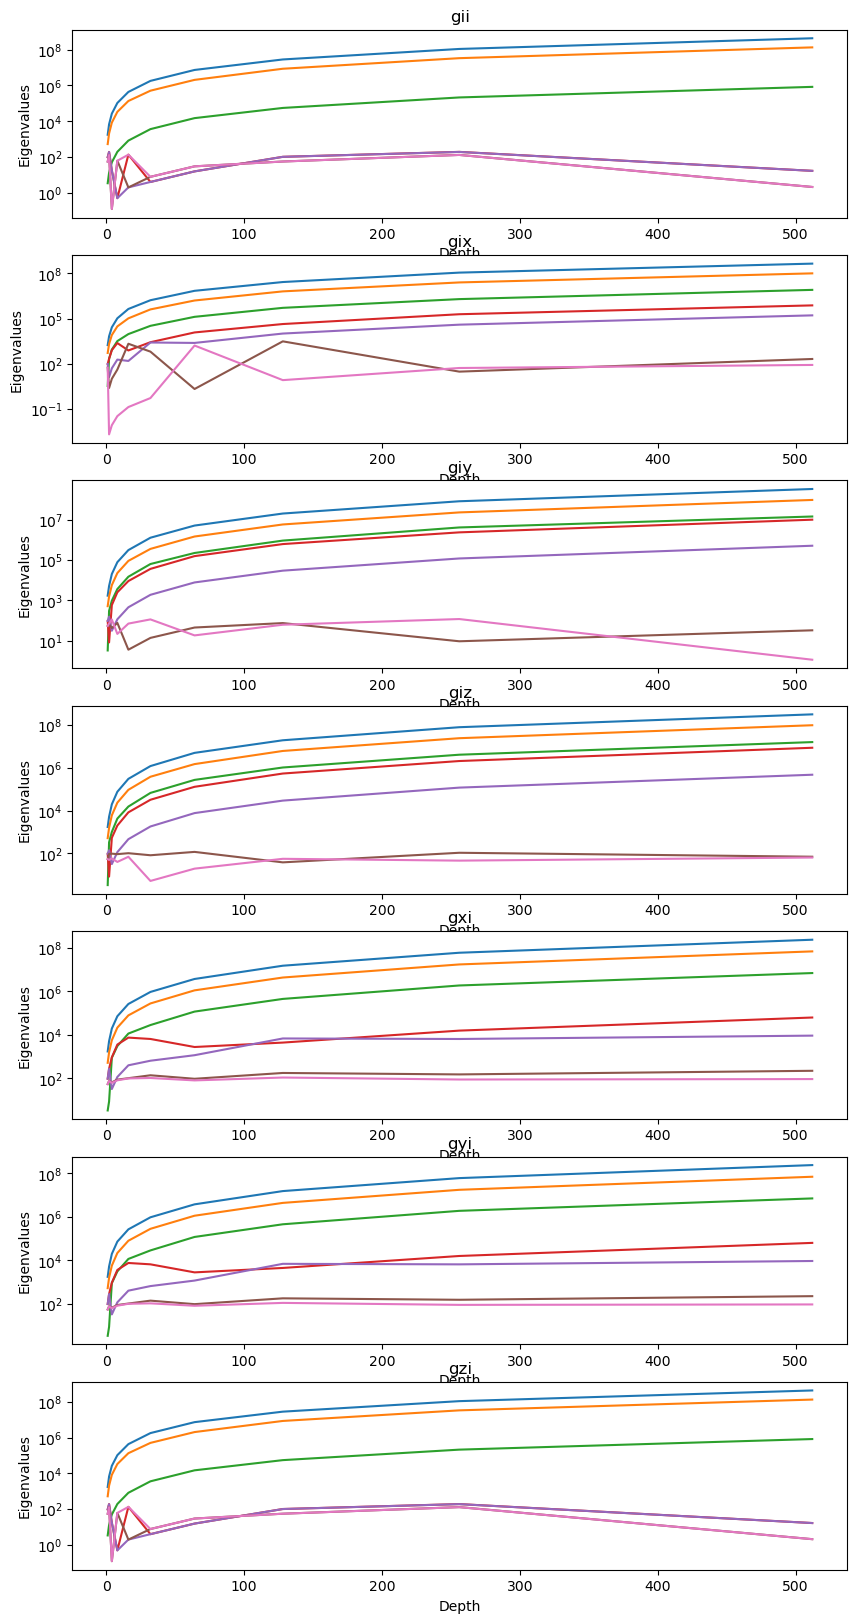

In [ ]:
# make a plot of the eigenvalues of the fisher information for the different circuits as a function of depth
fig, axs = plt.subplots(len(SP_DICT), 1, figsize=(10, 20))

all_evals = np.zeros((len(ds), len(SP_DICT), 7))
for id_d, d in enumerate(ds):
    fisherMats_SPOp_di = circuit_fisher_mats(all_fmatsDi[id_d], all_possible_circuits)
    for id_sp, sp_op in enumerate(SP_DICT.keys()):
        if sp_op in fisherMats_SPOp_di.keys():
            all_evals[id_d, id_sp, :] = abs(np.linalg.eigvals(fisherMats_SPOp_di[sp_op]))
for id_sp, sp_op in enumerate(SP_DICT.keys()):
    axs[id_sp].plot(ds, all_evals[:, id_sp, :])
    axs[id_sp].set_title(sp_op)
    axs[id_sp].set_xlabel('Depth')
    axs[id_sp].set_ylabel('Eigenvalues')
    axs[id_sp].set_yscale('log')

In [ ]:
all_evals

array([[1.20739992e+04, 3.63194139e+03, 2.34414029e+01, 6.77482572e+02,
        6.76285372e+02, 3.82595169e+02, 3.81619371e+02],
       [4.04877808e+04, 1.23493274e+04, 7.59521353e+01, 8.06179873e+02,
        8.21634944e+02, 1.35288118e+03, 1.38484353e+03],
       [1.57283278e+05, 4.74097458e+04, 2.89185013e+02, 3.09889789e+03,
        3.18358839e+03, 1.48947209e+03, 1.47355871e+03],
       [6.08451468e+05, 1.84885211e+05, 1.25823398e+04, 1.12230972e+04,
        1.08504241e+03, 4.60224576e+03, 4.86199201e+03],
       [2.42312761e+06, 7.13206915e+05, 4.24125323e+03, 4.02455858e+04,
        3.11474270e+04, 1.80914957e+04, 1.39306371e+04],
       [9.48015172e+06, 2.75488007e+06, 1.34970396e+05, 1.52788730e+04,
        8.40796959e+04, 6.75998338e+04, 4.58480311e+04],
       [3.85987366e+07, 1.10587956e+07, 6.08640886e+04, 5.17581200e+05,
        1.89311989e+05, 2.58388300e+05, 2.89024400e+05],
       [1.51023766e+08, 4.45333647e+07, 2.13508187e+06, 2.28355978e+05,
        7.09177544e+05, 1

Text(0, 0.5, 'Eigenvalues')

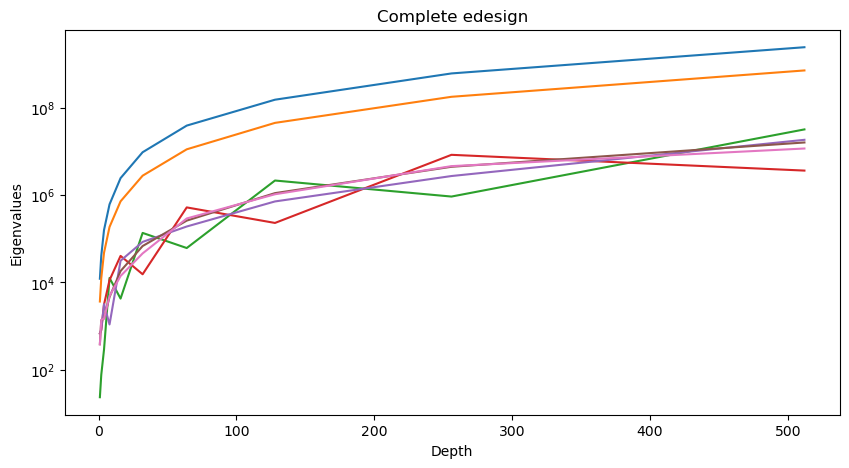

In [ ]:
# make a plot of the eigenvalues of the fisher information for the complete edesign as a function of depth
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
all_evals = np.zeros((len(ds), 7))
for id_d, d in enumerate(ds):
    fisherMat_di = np.sum(all_fmatsDi[id_d], axis=0)
    all_evals[id_d, :] = abs(np.linalg.eigvals(fisherMat_di))
axs.semilogy(ds, all_evals)
axs.set_title('Complete edesign')
axs.set_xlabel('Depth')
axs.set_ylabel('Eigenvalues')

In [ ]:
from tqdm import tqdm

In [19]:
def score_fisher_info_mat(fmat):
    """
    Calculates the score of a new Fisher Information Matrix based on the old one
    """
    evals = np.linalg.eigvals(fmat)
    np.clip(evals, 1e-20, None, out=evals)
    return np.sum(np.log(evals.real))

def find_optimal_circuit_list(xstate, d, circ_defs, num_probe_circuits=7, fisher_info_mats=None):
    """
    Finds a set of circuits that maximize the total Fisher Information
    """
    if fisher_info_mats is None:
        fisher_info_mats = circuit_list_fisher_mats(xstate, d, circ_defs)
    
    # find the optimal set of circuits
    optimal_circuits = []
    total_fisher_info = np.zeros((7, 7))
    for _ in tqdm(range(num_probe_circuits)):
        scores = np.zeros(len(circ_defs))
        for idx, (prep, meas, sp_op) in enumerate(circ_defs):
            if sp_op in optimal_circuits:
                scores[idx] = -np.inf
            else:
                scores[idx] = score_fisher_info_mat(total_fisher_info + fisher_info_mats[idx, :, :])
        optimal_circuit_idx = np.argmax(scores)
        optimal_circuits.append(circ_defs[optimal_circuit_idx])
        total_fisher_info += fisher_info_mats[optimal_circuit_idx, :, :]
    return optimal_circuits

In [20]:
# find the optimal set of circuits for fixed depths
ds = [1, 2, 3]
edesign = {d : find_optimal_circuit_list(perturbed_state, ds[i], all_possible_circuits, num_probe_circuits=8) for i, d in enumerate(ds)}

NameError: name 'tqdm' is not defined

In [17]:
edesign

NameError: name 'edesign' is not defined

In [ ]:
# find an estimate by minimizing the KL divergence
from scipy.optimize import minimize
results = minimize(lambda x: edesign_kl_div(perturbed_state, x, edesign), perturbed_state)

def edesign_kl_div(state, estimate, edesign):
    score = 0
    for d, circ_defs in edesign.items():
        true = model_probability(state, d, circ_defs)
        pred = model_probability(estimate, d, circ_defs)
        score += np.sum(kl_div(true, pred))
    return score

def make_minimum_kl_estimate(state, initial_estimate, edesign):
    results = minimize(lambda x: edesign_kl_div(state, x, edesign), initial_estimate)
    return results.x

In [ ]:
state0 = perturbed_state
Pinitial = 1e-1*np.eye(7)
xinitial = np.random.multivariate_normal(state0, Pinitial)

In [ ]:
make_minimum_kl_estimate(state0, xinitial, {1: edesign[1]})

array([-0.68539544,  0.06348878,  0.16378495,  0.88771568,  0.68539558,
        0.06349087, -0.03621441])

Text(0, 0.5, 'Eigenvalues')

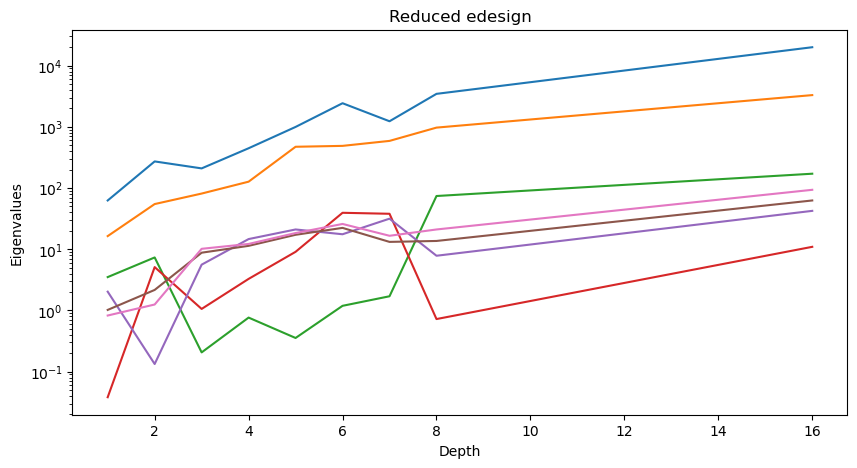

In [ ]:
# make a plot of the eigenvalues of the fisher information for the reduced edesign as a function of depth
fmatsDi = [circuit_list_fisher_mats(perturbed_state, d, edesign[d]) for d in edesign.keys()]
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
all_evals = np.zeros((len(ds), 7))
for id_d, d in enumerate(ds):
    fisherMat_di = np.sum(fmatsDi[id_d], axis=0)
    all_evals[id_d, :] = abs(np.linalg.eigvals(fisherMat_di))
axs.semilogy(ds, all_evals)
axs.set_title('Reduced edesign')
axs.set_xlabel('Depth')
axs.set_ylabel('Eigenvalues')

In [ ]:
def model_probability(xstate, d, circ_defs):
    """
    Calculates the probability of the model given a set of circuits
    """
    probs = np.zeros(len(circ_defs))
    for idx, (prep, meas, sp_op) in enumerate(circ_defs):
        probs[idx] = probability(xstate, d, PREPS_DICT[prep], MEAS_DICT[meas], SP_DICT[sp_op])
    return probs

def make_observation(xstate, d, circ_defs, num_shots):
    """
    Makes an observation of the model given a set of circuits
    """
    probs = model_probability(xstate, d, circ_defs)
    return np.array([np.random.binomial(num_shots, probs[i])/num_shots for i in range(len(circ_defs))])

def model_jacobian(xstate, d, circ_defs):
    """
    Calculates the Jacobian of the model given a set of circuits
    """
    jacobian = np.zeros((len(circ_defs), len(xstate)))
    for idx, (prep, meas, sp_op) in enumerate(circ_defs):
        jacobian[idx, :] = prob_grad(xstate, d, PREPS_DICT[prep], MEAS_DICT[meas], SP_DICT[sp_op])
    return jacobian


In [ ]:
class KalmanFilter:
    def __init__(self, xinitial, Pinitial, Q=None, record_history=True) -> None:
        self.x = xinitial
        self.P = Pinitial
        if Q is None:
            self.Q = np.zeros((len(xinitial), len(xinitial)))
        else:
            self.Q = Q
        if record_history:
            self.history = {'x': [self.x], 'P': [self.P]}

    def predict(self):
        # TODO : implmenet controls
        self.x = self.x
        self.P = self.P + self.Q

    def update(self, observation, d, circ_defs, R, iterative=False, max_iter=100, tol=1e-6):
        if not iterative:
            jacobian = model_jacobian(self.x, d, circ_defs)
            prediction = model_probability(self.x, d, circ_defs)
            S = jacobian@self.P@jacobian.T + R
            K = self.P@jacobian.T@np.linalg.inv(S)
            self.x = self.x + K@(observation - prediction)
            self.P = self.P - K@jacobian@self.P
        elif iterative:
            for i in range(max_iter):
                jacobian = model_jacobian(self.x, d, circ_defs)
                prediction = model_probability(self.x, d, circ_defs)
                S = jacobian@self.P@jacobian.T + R
                K = self.P@jacobian.T@np.linalg.inv(S)
                self.x = self.x + K@(observation - prediction)
                if np.linalg.norm(K@(observation - prediction)) < tol:
                    print("Converged after {} iterations".format(i))
                    break
                if i == max_iter - 1:
                    print("Failed to converge after {} iterations".format(i))
                    print("resdiual = {}".format(np.linalg.norm(K@(observation - prediction))))
            self.P = self.P - K@jacobian@self.P
        else: 
            raise ValueError("iterative must be True or False")
        if hasattr(self, 'history'):
            self.history['x'].append(self.x)
            self.history['P'].append(self.P)

    def plot_rms_history(self, xtrue, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        rms_history = np.zeros(len(self.history['x']))
        for idx, x in enumerate(self.history['x']):
            rms_history[idx] = np.linalg.norm(x - xtrue)
        ax.plot(rms_history)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('RMS Error')

    def plot_expected_innovations(self, edesign, xtrue, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ds = list(edesign.keys())
        num_circ_defs = len(edesign[ds[0]])
        innovations = np.zeros((num_circ_defs, len(ds)))
        for idx, d in enumerate(ds):
            innovations[:, idx] = make_observation(xtrue, d, edesign[d], 100) - make_observation(self.x, d, edesign[d], 100)
        ax.plot(ds, innovations.T)
        ax.set_xlabel('Depth')
        ax.set_ylabel('Innovation')


    

        
        

    def run(self, observations, d, circ_defs, R):
        for observation in observations:
            self.predict()
            self.update(observation, d, circ_defs, R)
            if hasattr(self, 'history'):
                self.history['x'].append(self.x)
                self.history['P'].append(self.P)
        return self.x, self.P

In [ ]:
def plot_kl_divergence(edesign, xtrue, xestimate, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ds = list(edesign.keys())
    kl_divs = np.zeros(len(ds))
    for idx, d in enumerate(ds):
        true = model_probability(xtrue, d, edesign[d])
        pred = model_probability(xestimate, d, edesign[d])
        kl_divs[idx] = np.sum(kl_div(true, pred))
    ax.plot(ds, kl_divs)
    ax.set_xlabel('Depth')
    ax.set_ylabel('KL Divergence')

In [ ]:
from scipy.special import kl_div

In [ ]:
def R_worst_case(num_circ_defs, num_shots):
    return (0.25/num_shots)*np.eye(num_circ_defs)

In [ ]:
state0 = perturbed_state
Pinitial = 1e-1*np.eye(7)
xinitial = np.random.multivariate_normal(state0, Pinitial)
num_shots = 1000
num_circ_defs = 8
R = R_worst_case(num_circ_defs, num_shots)


In [ ]:
kf = KalmanFilter(xinitial, Pinitial, record_history=True)
for d, circ_def in edesign.items():
    observation = make_observation(state0, d, circ_def, num_shots)
    kf.update(observation, d, circ_def, R, iterative=True, max_iter=10, tol=1e-6)

Failed to converge after 2 iterations
resdiual = 0.016942281857599998
Failed to converge after 2 iterations
resdiual = 0.014602605779930476
Failed to converge after 2 iterations
resdiual = 0.016248173882935504
Failed to converge after 2 iterations
resdiual = 0.011447338767543305
Failed to converge after 2 iterations
resdiual = 0.0035309547360172955
Failed to converge after 2 iterations
resdiual = 0.00769026781588626
Failed to converge after 2 iterations
resdiual = 0.00917854409284618
Failed to converge after 2 iterations
resdiual = 0.010702982158302158
Failed to converge after 2 iterations
resdiual = 0.0036600467037973586


In [ ]:
kf.history['x'] 

[array([ 0.08706184,  0.12599743,  0.00464034,  0.07067641,  1.37610877,
        -0.13323214, -0.19013566]),
 array([ 0.03875573,  0.03645069,  0.06717527,  0.11340732,  1.41587829,
         0.07252656, -0.09807254]),
 array([ 0.01677647,  0.07656004,  0.09513512,  0.13306243,  1.40959149,
         0.10626147, -0.07337206]),
 array([ 0.00142076,  0.12700186,  0.11426121,  0.14671506,  1.40072931,
         0.14253457, -0.08545275]),
 array([ 0.03082379,  0.13599935,  0.11068126,  0.11766196,  1.40083528,
         0.14733001, -0.08836193]),
 array([ 0.02694832,  0.1485893 ,  0.11940862,  0.11963992,  1.40163648,
         0.1467318 , -0.0850305 ]),
 array([ 0.07802092,  0.1393653 ,  0.12543527,  0.06667797,  1.41183379,
         0.13172076, -0.06423111]),
 array([ 0.05836872,  0.12805927,  0.12220697,  0.09076488,  1.41507542,
         0.12214378, -0.07465235]),
 array([ 0.03256811,  0.12089338,  0.12428914,  0.11865232,  1.41677116,
         0.12158334, -0.06986439]),
 array([ 0.07394311

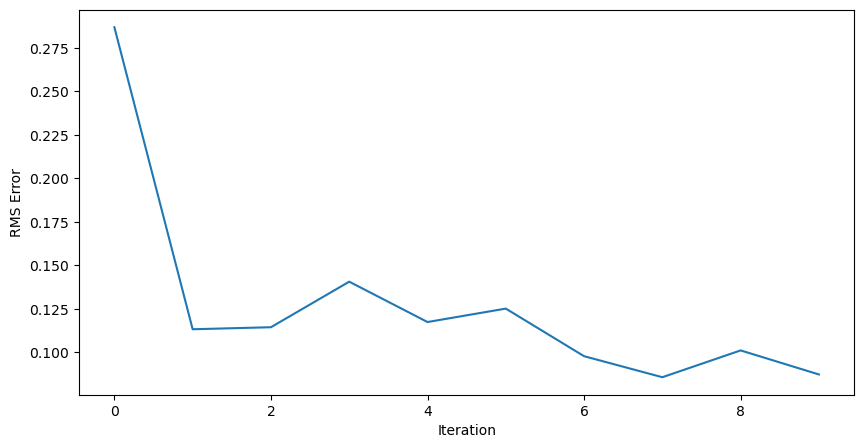

In [ ]:
kf.plot_rms_history(state0)

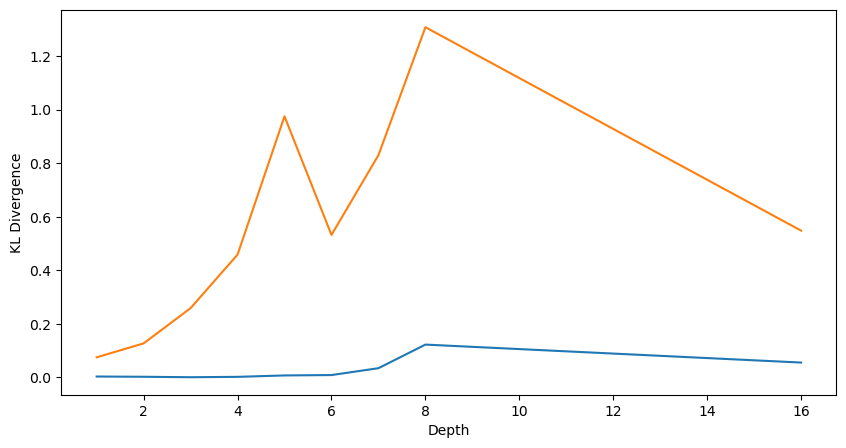

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_kl_divergence(edesign, state0, kf.x, ax=axs)
plot_kl_divergence(edesign, state0, xinitial, ax=axs)


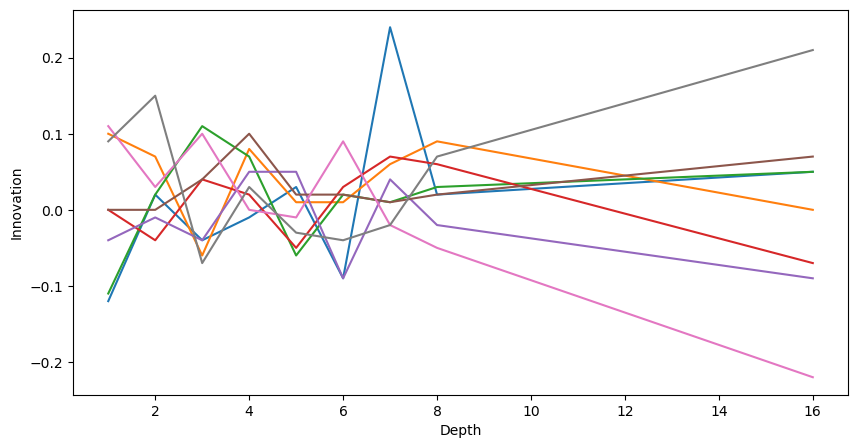

In [ ]:
kf.plot_expected_innovations(edesign, state0)

AttributeError: 'KalmanFilter' object has no attribute 'plot_kl_divergence'

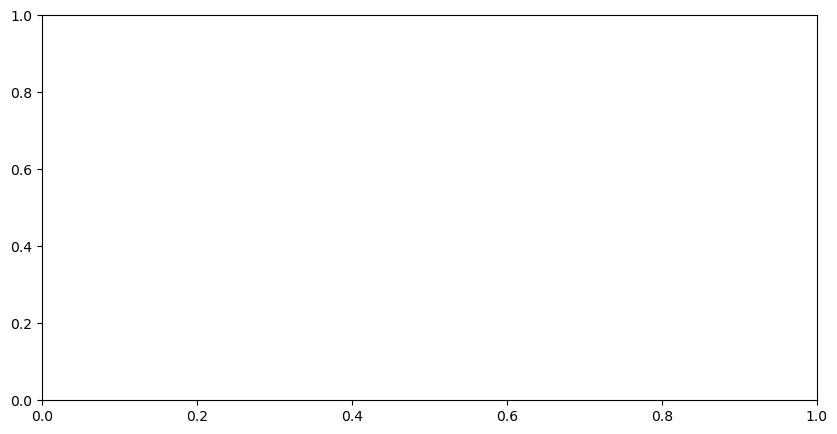

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
kf.plot_kl_divergence(edesign, state0, ax=axs)
kf.plot_kl_divergence(edesign, state0, ax=axs)


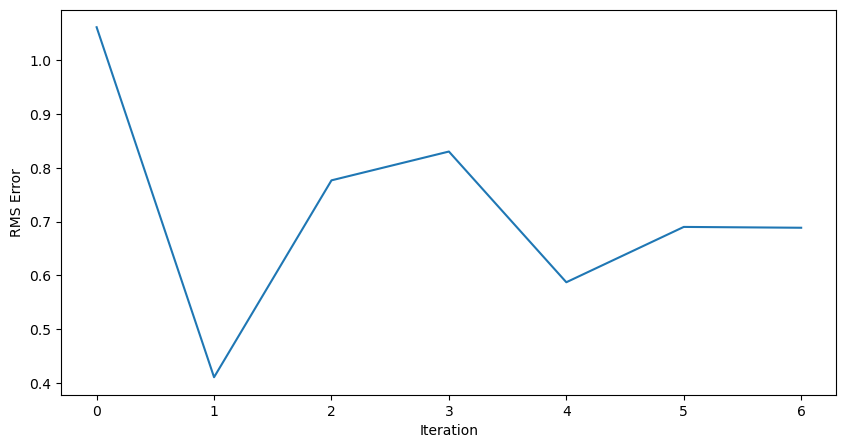

In [ ]:
kf.plot_rms_history(state0)

In [ ]:
kf.plot_expected_innovation(

[array([ 0.07660412,  0.11142771,  0.09441888,  0.13352592,  1.45869359,
         0.06138588, -0.09301108]),
 array([ 0.07261645,  0.07595985,  0.10080858,  0.13975346,  1.4608976 ,
         0.09027354, -0.08152677]),
 array([ 0.06818878,  0.0873687 ,  0.09572775,  0.14287947,  1.46032349,
         0.09864881, -0.09644917]),
 array([ 0.06575012,  0.09847122,  0.09739939,  0.14490297,  1.45813866,
         0.10198968, -0.1019411 ]),
 array([ 0.08443162,  0.09675444,  0.10468955,  0.12629277,  1.45751407,
         0.10631962, -0.09757529]),
 array([ 0.12576294,  0.09444303,  0.10251067,  0.08104499,  1.46121728,
         0.11425715, -0.09196497]),
 array([ 0.11009689,  0.1104934 ,  0.1012865 ,  0.09717808,  1.45989448,
         0.10311747, -0.09963415]),
 array([ 0.09845437,  0.10872091,  0.09128698,  0.10930433,  1.46148605,
         0.09504483, -0.09860564]),
 array([ 0.09837668,  0.10729   ,  0.09056657,  0.10919639,  1.4612707 ,
         0.0982375 , -0.09914429]),
 array([ 0.09964983

In [ ]:
def make_brownian_trajectory(Q, num_steps):
    """
    Makes a Brownian trajectory with covariance Q
    """
    return np.random.multivariate_normal(np.zeros(len(Q)), Q, num_steps)

def filter_trajectory(kf, trajectory, d, circ_defs, R):
    """
    Filters a Brownian trajectory with the Kalman Filter
    """
    observations = np.zeros((len(trajectory), len(circ_defs)))
    for idx, state in enumerate(trajectory):
        kf.predict()
        observations[idx, :] = make_observation(state, d, circ_defs, 1000)
        kf.update(observations[idx, :], d, circ_defs, R)
    return observations
    

In [ ]:
kf = KalmanFilter(perturbed_state, np.eye(7), Q=np.eye(7)*0.01)
trajectory = make_brownian_trajectory(np.eye(7)*0.01, 100)
observations = filter_trajectory(kf, trajectory, 100, optimal_circs, R_worse_case(len(optimal_circs), 1000))

[[0.00025 0.      0.      0.      0.      0.      0.      0.     ]
 [0.      0.00025 0.      0.      0.      0.      0.      0.     ]
 [0.      0.      0.00025 0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.00025 0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.00025 0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.00025 0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.00025 0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.00025]]
(7, 8)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 7 is different from 8)